# Regresion Lineal

Tanto esta tarea como la tarea 3 la hicimos Regina García y Fernanda Hinze juntas. 

In [2]:
#Primero vamos a importar lo que usaremos en los ejercicios.
%pylab inline
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, widgets

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Una vez que ya leímos todo vemos que vamos a usar regresión lineal para todo, así que decidimos ponerla de una vez. Lo tomamos tal cual de la clase:
class RegresionLineal:
    def __init__(self, alpha=0.03, max_iters=10000, tols=0.00001):
        """
        Parámetros.
        ---------------
        alpha = Learning rate
        max_iters = Número máximo de iteraciones
        tols = definición de convergencia
        """
        self.alpha = alpha
        self.max_iters = max_iters
        self.tols = tols
        self.breaking_iteration = None
        self.historia = {'costo':[], 'beta':[]}  # Con fines de graficación
        
    def gradientDescent(self, x, y):
        """
        Parámetros:
        ---------------
        x = vector de entrenamiento de features
        y = vector de entrenamiento de variable a predecir (target)
        """    
        
        # ajustamos el vector de features
        unos = np.ones((x.shape[0], 1))
        Xt = x.reshape(x.shape[0], 1)
        Xt = np.concatenate((unos, Xt), axis=1)
        
        i = 0
        prep_J = 0
        m, n = Xt.shape
        self.beta = np.zeros(n) 
        
        while i < self.max_iters:     
            # Actualizamos beta
            self.beta = self.beta - self.alpha * self.gradiente(Xt, y)
            
            J = self.costo(Xt, y)
            
            if abs(J - prep_J) <= self.tols:
                print('La función convergió con beta: %s en la iteración %i' % ( str(self.beta), i ))
                self.breaking_iteration = i
                break
            else:
                prep_J = J
            
            self.historia['costo'].append(J)
            self.historia['beta'].append(self.beta)                
            i += 1
    
    def hipotesis(self, x):
        return np.dot(x, self.beta)
    
    def costo(self, x, y):
        m = x.shape[0]
        error = self.hipotesis(x) - y
        return np.dot(error.T, error) / (2 * m) 
    
    def gradiente(self, x, y):
        m = x.shape[0]
        error = self.hipotesis(x) - y        
        return np.dot(x.T, error) / m

In [23]:
#Tomamos también el plot del modelo directo de la clase
def plotModelo(x,y,rl,iteracion):
    modelo = lambda x,b,m: b + m*x # función para graficar el modelo
    
    _beta = rl.historia['beta'][iteracion]

    fig, ax = plt.subplots(1,2, figsize=(10,6))
    ax[0].scatter(x,y, label="datos")
    ax[0].plot(x, modelo(x, _beta[0], _beta[1]), label="int: %1.2f, pen: %1.2f" % (_beta[0], _beta[1]))
    ax[0].set_xlabel('Eje x')
    ax[0].set_ylabel('Eje y')
    ax[0].legend(loc="best")
    #ax[0].set_xlim(0, max(x))
    #ax[0].set_ylim(0, max(y))
    
    costo  = rl.historia['costo']
    
    iteraciones = [i for i in range(0, len(costo))]
    ax[1].plot(iteraciones, costo, 'g', label="costo")
    ax[1].plot(iteracion, costo[iteracion], 'or', label="iteracion")
    ax[1].set_xlabel('Iteraciones')
    ax[1].set_ylabel('Costo')
    ax[1].legend(loc="best")

## Problema 1

**(a)** Usando **SimPy** demostrar que 

$$
\frac{\partial}{\partial \beta_j} \textbf{J}(\beta) = \frac{1}{m}\sum_{i=1}^{m}\left(\hat{y}(x^{(i)}) - y(x^{(i)})\right) \cdot x^{(i)}_j
$$
Para el caso de $\beta_0, \beta_1$ en $J(\beta_0,\beta_1)$.

In [4]:
J = Function('J')
m = Symbol('m')
i = Symbol('i')
b0 = Symbol('beta_0')
b1 = Symbol('beta_1')
x = Symbol('x')
y = Symbol('y')
n = Symbol('n')

In [5]:
J = Sum((Indexed(y,i) - b0 - b1*Indexed(x,i))**2, (i, 1, n))/(2*n) #Por prueba y error nos damos cuenta que los paréntesis de el 2*n sí es indispensable
J

Sum((-beta_0 - beta_1*x[i] + y[i])**2, (i, 1, n))/(2*n)

In [6]:
Jd = Function('Jd') #Jd de la Derivada de J
Jd = simplify(Derivative(Sum((Indexed(y,i) - b0 - b1*Indexed(x,i))**2, (i, 1, n))/(2*n), b0).doit())
Jd

Sum(beta_0 + beta_1*x[i] - y[i], (i, 1, n))/n

In [7]:
#Reescribimos para que coincida excatamente 
Jr = Function('Jr') #Jr de Reescribir J
Jr = simplify(Derivative(J, b1).doit())
Jr

Sum((beta_0 + beta_1*x[i] - y[i])*x[i], (i, 1, n))/n

In [10]:
#Otra forma sería derivar respecto a las 2 betas de un jalón
derivadab0 = simplify(Derivative(J, b0))
derivadab1 = simplify(Derivative(J, b1))
derivadab0, derivadab1

(Sum(2*beta_0 + 2*beta_1*x[i] - 2*y[i], (i, 1, n))/(2*n),
 Sum(2*(beta_0 + beta_1*x[i] - y[i])*x[i], (i, 1, n))/(2*n))

## Problema 2

Usando el ejemplo de la clase ( i.e. Los archivos `edad.dat` y `altura.dat` contienen las mediciones de las estaturas (en metros) de varios niños entre las edad de 2 y 8 años. Cada _tupla_ de altura y edad, constituyen un ejemplo de entrenamiento $(x^{(i)}, y^{(i)})$ de nuestros datos. Hay $m = 50$ datos para entrenar que usaremos para realizar un modelo de regresión lineal. ) :

**(a)** Grafique $\textbf{J}(\beta)$ del ejercicio en $3D$ y en una gráfica de contorno.

In [44]:
edad = np.loadtxt('edad.dat')
altura = np.loadtxt('altura.dat')

#Para graficar J(beta) tenemos que tener J(beta)
def J(beta0, beta1):
    costo = 0
    for i in range(len(altura)):
        costo += ((altura[i] - beta0 - beta1*edad[i])**2/(2*len(altura)))
        return costo
    
b0 = np.arange(-2,2,0.01)
b1 = np.arange(-2,2,0.01)
Beta0,Beta1 = np.meshgrid(b0,b1)
costo = J(Beta0,Beta1)

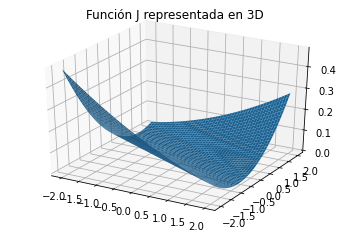

In [45]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection = '3d')
ax.set_title("Función J representada en 3D")
ax.plot_surface(Beta0,Beta1,costo)

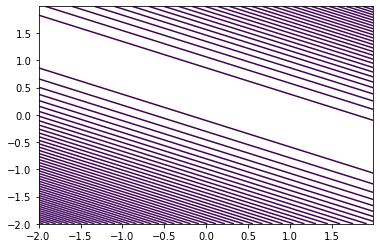

In [46]:
#Gráfica de contorno
fig = plt.figure() 
plt.contour(Beta0,Beta1,costo, levels = np.arange(0,10,0.01))

**(b)** Indique con un punto el valor de $\textbf{J}(\beta)$ en la última iteración.

In [47]:
r = RegresionLineal(alpha=0.03, max_iters=10000, tols=0.00001);
e = r.gradientDescent(edad,altura)
e

La función convergió con beta: [0.57873101 0.095071  ] en la iteración 455


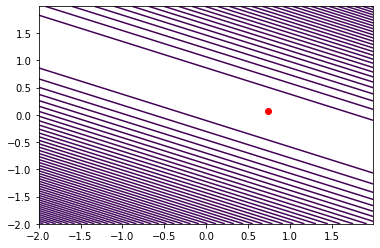

In [15]:
fig = plt.figure()
plt.contour(Beta0,Beta1,costo, levels = np.arange(0,10,0.01))
plt.plot(0.73, 0.07, "ro")

**(c)** Modifique el _widget_ para mostrar conforme pasan las iteraciones como el valor de $\textbf{J}(\beta)$ se acerca al mínimo en la gráfica de contorno.

In [48]:
r = RegresionLineal(alpha=0.03, max_iters=10000, tols=0.000001)
r.gradientDescent(edad,altura)

ultima = (r.breaking_iteration - 1) if r.breaking_iteration else (r.max_iters - 1)

La función convergió con beta: [0.69583921 0.07376462] en la iteración 822


**(d)** Agrega al _widget_ un control para modificar $\alpha$ (habrá que agregar el entrenamiento del modelo a la función que estás realizando para este _widget_)

In [49]:
# coments coments coments
def Alpha(miniAlpha):
    modificacion = RegresionLineal(alpha = miniAlpha, max_iters = 10000, tols=0.00001)
    return modificacion.gradientDescent (edad, altura)

interact(Alpha, miniAlpha=(0.000003, r.alpha, 0.0001))

interactive(children=(FloatSlider(value=0.014903, description='miniAlpha', max=0.03, min=3e-06, step=0.0001), …

<function __main__.Alpha(miniAlpha)>

## Problema 3

**(a)**  Usando los datos de `chirps.txt`

Entrenar una regresión lineal. Grafique los datos y el mejor modelo. Explique como llegó a los valores de $\alpha$. ¿Coinciden con los mostrados en la página web?


**NOTA**: Datos obtenidos de [aquí](http://mathbits.com/MathBits/TISection/Statistics2/linearREAL.htm)


In [11]:
#Leemos el archivo y guardamos en matrices los datos

tiempoMatriz = []
temperaturaMatriz = []
chirps = open('chirps.txt', "r")
chirps.readline()
for line in chirps: 
    reader = line.split("\t")
    tiempoMatriz.append(float(reader[0]))
    temperaturaMatriz.append(float(reader[1]))
    
chirps = np.array(tiempoMatriz)
tiempo = np.array(temperaturaMatriz)

Text(0, 0.5, 'Temperatura en grados Fahrenheit')

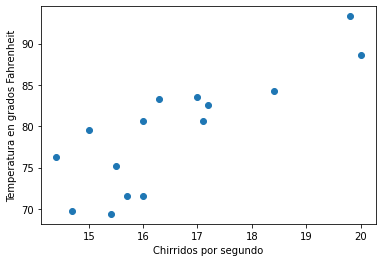

In [12]:
#Graficamos los datos
plt.scatter(chirps, tiempo, label="Los datos")
plt.xlabel("Chirridos por segundo")
plt.ylabel("Temperatura en grados Fahrenheit")

In [14]:
#"Entrenamos" la regresión lineal 
r = RegresionLineal(alpha = 0.003, max_iters = 1000000, tols = 0)
r.gradientDescent(chirps, tiempo)

La función convergió con beta: [22.84871924  3.41033872] en la iteración 384673


## Problema 4

**(a)** Usando los datos del [cuarteto de Anscombe](http://en.wikipedia.org/wiki/Anscombe%27s_quartet) Calcule la regresión lineal ¿Qué sucede?

In [19]:
#Again, leemos el archivo y vamos guardando los datos de forma ordenada en una matriz. 
cuartetoMatriz = np.loadtxt("anscombe.txt")

cuartetoMatrizOrdenada = [[],[],[],[],[],[],[],[]]
for i in cuartetoMatriz: 
    k = 0
    for j in i:
        cuartetoMatrizOrdenada[k].append(j)
        k += 1
cuartetoMatrizOrdenada = np.array(cuartetoMatrizOrdenada)

La función convergió con beta: [3.00008683 0.50009131] en la iteración 41286


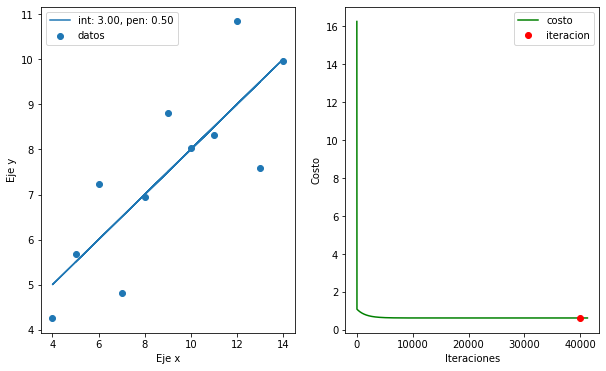

In [24]:
#Lo que haremos es entrenar la regresión lineal para cada uno de los cuatro conjuntos de datos
#Vemos a dónde converge
#Por último graficamos con la línea recta correspondiente
regresion1 = RegresionLineal(alpha = 0.003, max_iters = 100000, tols = 0)
regresion1.gradientDescent(cuartetoMatrizOrdenada[0], cuartetoMatrizOrdenada[1])
plotModelo(cuartetoMatrizOrdenada[0], cuartetoMatrizOrdenada[1], regresion1,40000)

La función convergió con beta: [3.00090503 0.5000004 ] en la iteración 41305


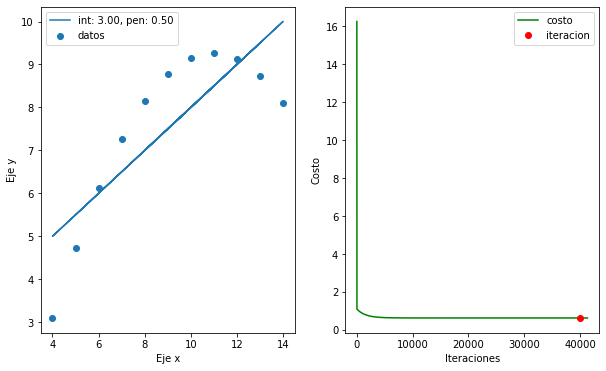

In [25]:
#Mismo procedimiento para el conjunto 2
regresion2 = RegresionLineal(alpha = 0.003, max_iters = 100000, tols = 0)
regresion2.gradientDescent(cuartetoMatrizOrdenada[2], cuartetoMatrizOrdenada[3])
plotModelo(cuartetoMatrizOrdenada[2], cuartetoMatrizOrdenada[3], regresion2,40000)

La función convergió con beta: [3.00244952 0.49972777] en la iteración 40652


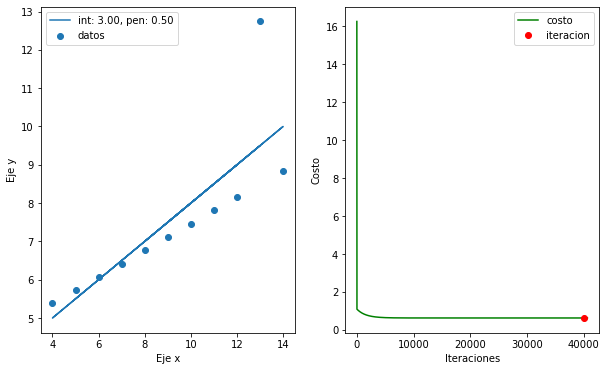

In [26]:
#Mismo procedimiento para el conjunto 3
regresion3 = RegresionLineal(alpha = 0.003, max_iters = 100000, tols = 0)
regresion3.gradientDescent(cuartetoMatrizOrdenada[4], cuartetoMatrizOrdenada[5])
plotModelo(cuartetoMatrizOrdenada[4], cuartetoMatrizOrdenada[5], regresion3,40000)

La función convergió con beta: [3.00172424 0.49990939] en la iteración 42197


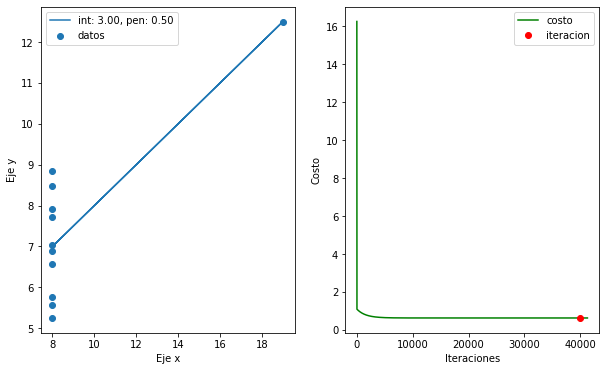

In [27]:
#Mismo procedimiento para el conjunto 4
regresion4 = RegresionLineal(alpha = 0.003, max_iters = 100000, tols = 0)
regresion4.gradientDescent(cuartetoMatrizOrdenada[6], cuartetoMatrizOrdenada[7])
plotModelo(cuartetoMatrizOrdenada[6], cuartetoMatrizOrdenada[7], regresion1,40000)

## Problema 5

Use el archivo `radioactive_decay.dat`

In [35]:
#Leemos los datos y los guardamos en matrices otra vez
tiempoMatriz = []
datosMatriz = []
radioactive_decay = open('radioactive_decay.txt', "r")
radioactive_decay.readline()
for line in radioactive_decay:
    leoLinea = line.split("\t")
    tiempoMatriz.append(float(leoLinea[0]))
    datosMatriz.append(float(leoLinea[1]))
    
tiempo = np.array(tiempoMatriz)
datos = np.array(datosMatriz)

**(a)** Grafique los datos ¿Qué forma tienen?

Text(0, 0.5, 'Material radioactivo que queda')

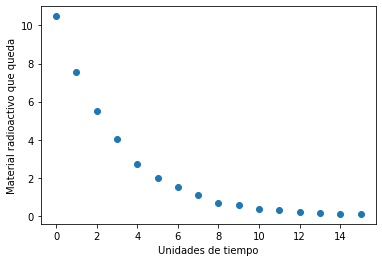

In [30]:
plt.scatter(tiempo,datos, label = "Todos los datos")
plt.xlabel("Unidades de tiempo")
plt.ylabel("Material radioactivo que queda")

--> Es la forma de una exponencial

**(b)** ¿Qué transformación se le ocurre para linearizarlos? Explique y grafique de nuevo. Guarde los datos transformados en un archivo llamado `transform_radioactive_decay.txt`

--> llamamos a nuestro archivo diferente pero nos dimos cuenta después, ¡perdón!

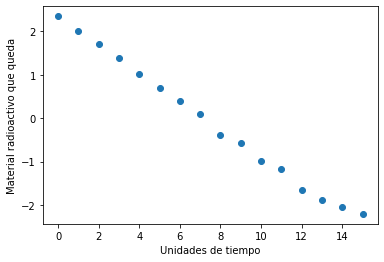

In [31]:
datosArreglo = []
for i in datosMatriz: 
    datosArreglo.append(np.log(i))

datosArreglo
plt.scatter(tiempo, datosArreglo, label= "Nuevos datos")
plt.xlabel("Unidades de tiempo")
plt.ylabel("Material radioactivo que queda")
np.savetxt('Nuevos_datos_radioactive_decay.txt', datosArreglo)

**(c)** Aplique la regresión lineal a este conjunto de datos transformado, leyendo los datos del archivo recién creado.

In [36]:
nuevosDatosArreglo = np.loadtxt('Nuevos_datos_radioactive_decay.txt')
primero = tiempo
segundo = nuevosDatosArreglo
reg = RegresionLineal(alpha = 0.003, max_iters = 100000, tols = 0.000001)
reg.gradientDescent(primero, segundo)

#plotModelo(primero, segundo, reg, 40000) nos costó graficarlo así porque nuestra función plotmodelo nos pide justo el número de iteración pero como no lo tenemos la verdad es que no supimos cómo corregirlo

La función convergió con beta: [ 2.2297646  -0.31015622] en la iteración 4342


**(d)** ¿Cuáles son los valores de $\beta$ que mejor ajustan? ¿Cuáles son el espacio sin transformar? Explique.

Sabemos por teoría que los mejores valores de beta son aquellos en los que la función de costo lleva a su valor mínimo. Sabemos que debemos de buscar el punto en donde la función convergió según nuestra regresión, sin embargo no nos queda muy claro cómo hacerlo (ya prácticamente).

--> Nota al pie: profesor de verdad muchas gracias por toda la comprensión a lo largo del curso, genuinamente nos gustó mucho y a pesar de que ninguna de las dos somos muy fans de programar, sentimos que aprendimos mucho y además los ejemplos fueron muy interactivos. Esta tarea nos tomó bastante tiempo, no entendíamos al 100% cómo funcionaba la regresión pero después de volver a ver la clase y pedirle ayuda a bendito YouTube salió casi todo. -Atte: Regina y Fernanda